In [4]:
ors = 5

In [5]:
import sys
sys.path.append('../_amigocloud')
import simplekml
from amigocloud import AmigoCloud
import pandas as pd
from shapely import wkb
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint
import os

In [6]:
# RUTA ONEDRIVE
ruta_data = r'G:'
# ruta de carpera donde estan las llaves
ruta = open('../ruta.txt')
ruta = ruta.readlines()[0]
# leer token
acceso = open(ruta + '/_keys/api_amigocloud.key','r')
api_token = acceso.readlines()[0]
acceso.close()
amigocloud = AmigoCloud(token=api_token)
amigocloud

# leer los dos shps de siembra y puntos de planificacion
path_cat = ruta_data + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\catastro_S09_MIERCOLES.shp'
path_puntos = ruta_data + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\PUNTOS_PLAN.shp'
path_plan = ruta_data + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\PLANIFICACION.shp'
path_xlsx_parte = ruta_data + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\parte_diario_pulverizacion.xlsx'

# ACTUALIZAR SHP PLANIFICACION

In [7]:
gdf_puntos = gpd.read_file(path_puntos)
gdf_cat = gpd.read_file(path_cat)

In [8]:
# filtrar la semana de interes
gdf_puntos_select = gdf_puntos[gdf_puntos['os'] == ors]
gdf_puntos_sem = gdf_puntos_select.copy()
#quita caracteres especiales
gdf_puntos_sem['unidad_04'] = gdf_puntos_sem['unidad_04'].str.replace(r'[\r\n\t]', '', regex=True)
gdf_puntos_sem

,unidad_03,unidad_04,os,obs,procesado,geometry
10,1530,C.I.T.T.C.A.,5,None,None,"MULTIPOINT (478316.821 8093899.451, 479528.594..."
11,41594,AGROPECUARIA CAMPO DULCE S.R.L.,5,None,None,"MULTIPOINT (487114.240 8094228.617, 487426.449..."


In [9]:
multipoint_gdf = gdf_puntos_sem.copy()

In [10]:
# Crear una lista para almacenar los nuevos registros de puntos individuales
point_records = []
# Iterar sobre cada registro en el GeoDataFrame original
for idx, row in multipoint_gdf.iterrows():
    multipoint_geom = row.geometry
    # Verificar si la geometría es de tipo multipunto
    if isinstance(multipoint_geom, MultiPoint):
        for point in multipoint_geom.geoms:
            # Crear un nuevo registro para cada punto individual
            new_record = row.copy()
            new_record.geometry = point
            point_records.append(new_record)
    else:
        # Si la geometría ya es un punto, simplemente añadir el registro original
        point_records.append(row)

# Crear un nuevo GeoDataFrame con los registros de puntos individuales
puntos_indi = gpd.GeoDataFrame(point_records, crs=multipoint_gdf.crs)

In [11]:
# puntos individuales
puntos_indi

,unidad_03,unidad_04,os,obs,procesado,geometry
10,1530,C.I.T.T.C.A.,5,None,None,POINT (478316.821 8093899.451)
10,1530,C.I.T.T.C.A.,5,None,None,POINT (479528.594 8094163.636)
10,1530,C.I.T.T.C.A.,5,None,None,POINT (479538.330 8093077.870)
10,1530,C.I.T.T.C.A.,5,None,None,POINT (479587.983 8093894.485)
11,41594,AGROPECUARIA CAMPO DULCE S.R.L.,5,None,None,POINT (487114.240 8094228.617)
11,41594,AGROPECUARIA CAMPO DULCE S.R.L.,5,None,None,POINT (487426.449 8094048.700)
11,41594,AGROPECUARIA CAMPO DULCE S.R.L.,5,None,None,POINT (487786.283 8094392.659)
11,41594,AGROPECUARIA CAMPO DULCE S.R.L.,5,None,None,POINT (487812.742 8094905.951)
11,41594,AGROPECUARIA CAMPO DULCE S.R.L.,5,None,None,POINT (487929.158 8093784.116)


<Axes: >

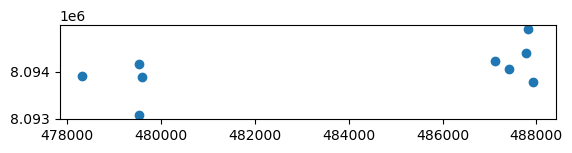

In [12]:
puntos_indi.plot()

In [13]:
# identifoca los lotes que se intersectan
gdf_lotes_cat = gpd.sjoin(gdf_cat, puntos_indi, how='inner', predicate='intersects')
# filtra los lotes intersectados en la capa original
poligonos_intersect_cat = gdf_cat.loc[gdf_cat.index.isin(gdf_lotes_cat.index)]
# copy
poligonos_intersect_cat = poligonos_intersect_cat.copy()
poligonos_intersect_cat = poligonos_intersect_cat[['unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area', 'soca', 'zona', 'geometry']]

In [14]:
# Cambiar el nombre de la columna 'old_name' a 'new_name'
poligonos_intersect_cat.rename(columns={'zona': 'inst'}, inplace=True)

In [15]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry
453,299.0,CITTCA,1530.0,C.I.T.T.C.A.,N25,3.127608,0.0,124,"POLYGON ((479500.907 8093827.318, 479495.821 8..."
454,299.0,CITTCA,1530.0,C.I.T.T.C.A.,N23,2.707825,0.0,124,"POLYGON ((479496.561 8094203.672, 479503.064 8..."
2138,299.0,CITTCA,1530.0,C.I.T.T.C.A.,N3,16.030289,0.0,124,"POLYGON ((478115.791 8094316.762, 478333.064 8..."
2162,299.0,CITTCA,1530.0,C.I.T.T.C.A.,S3,31.245430,0.0,124,"POLYGON ((479981.054 8092840.174, 479980.204 8..."
7557,577.0,SAN ANTONIO--IAG,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,L3,14.046489,0.0,50,"POLYGON ((487193.395 8094028.850, 487262.759 8..."
7558,577.0,SAN ANTONIO--IAG,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,L4,16.907230,0.0,50,"POLYGON ((487326.883 8094631.099, 487256.226 8..."
7560,577.0,SAN ANTONIO--IAG,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,L2,8.892186,0.0,50,"POLYGON ((487789.363 8093979.038, 487947.338 8..."
7562,577.0,SAN ANTONIO--IAG,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,L1,48.404143,0.0,50,"POLYGON ((487345.806 8094635.527, 488024.724 8..."
7564,577.0,SAN ANTONIO--IAG,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,L5,12.004987,0.0,50,"POLYGON ((488023.791 8094765.791, 487704.816 8..."


In [16]:
# CAMBIAR NOMBRE DATOS DE UNIDAD_03 Y UNDIAD_04 DE LOTES SOLICITADOS A LO INDICADO EN LOS PUNTOS
# Iterar sobre cada punto y encontrar el polígono que intersecta
for idx, point in puntos_indi.iterrows():
    point_geom = point.geometry
    matching_polygons = poligonos_intersect_cat[poligonos_intersect_cat.intersects(point_geom)]
    
    # Actualizar los campos de los polígonos que intersectan con los valores del punto
    for poly_idx in matching_polygons.index:
        poligonos_intersect_cat.at[poly_idx, 'unidad_03'] = point['unidad_03']
        poligonos_intersect_cat.at[poly_idx, 'unidad_04'] = point['unidad_04']

In [17]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry
453,299.0,CITTCA,1530.0,C.I.T.T.C.A.,N25,3.127608,0.0,124,"POLYGON ((479500.907 8093827.318, 479495.821 8..."
454,299.0,CITTCA,1530.0,C.I.T.T.C.A.,N23,2.707825,0.0,124,"POLYGON ((479496.561 8094203.672, 479503.064 8..."
2138,299.0,CITTCA,1530.0,C.I.T.T.C.A.,N3,16.030289,0.0,124,"POLYGON ((478115.791 8094316.762, 478333.064 8..."
2162,299.0,CITTCA,1530.0,C.I.T.T.C.A.,S3,31.245430,0.0,124,"POLYGON ((479981.054 8092840.174, 479980.204 8..."
7557,577.0,SAN ANTONIO--IAG,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,L3,14.046489,0.0,50,"POLYGON ((487193.395 8094028.850, 487262.759 8..."
7558,577.0,SAN ANTONIO--IAG,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,L4,16.907230,0.0,50,"POLYGON ((487326.883 8094631.099, 487256.226 8..."
7560,577.0,SAN ANTONIO--IAG,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,L2,8.892186,0.0,50,"POLYGON ((487789.363 8093979.038, 487947.338 8..."
7562,577.0,SAN ANTONIO--IAG,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,L1,48.404143,0.0,50,"POLYGON ((487345.806 8094635.527, 488024.724 8..."
7564,577.0,SAN ANTONIO--IAG,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,L5,12.004987,0.0,50,"POLYGON ((488023.791 8094765.791, 487704.816 8..."


In [18]:
# agrega los campos faltantes
poligonos_intersect_cat['os'] = ors

In [19]:
plan = poligonos_intersect_cat.copy()

In [20]:
plan

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,os
453,299.0,CITTCA,1530.0,C.I.T.T.C.A.,N25,3.127608,0.0,124,"POLYGON ((479500.907 8093827.318, 479495.821 8...",5
454,299.0,CITTCA,1530.0,C.I.T.T.C.A.,N23,2.707825,0.0,124,"POLYGON ((479496.561 8094203.672, 479503.064 8...",5
2138,299.0,CITTCA,1530.0,C.I.T.T.C.A.,N3,16.030289,0.0,124,"POLYGON ((478115.791 8094316.762, 478333.064 8...",5
2162,299.0,CITTCA,1530.0,C.I.T.T.C.A.,S3,31.245430,0.0,124,"POLYGON ((479981.054 8092840.174, 479980.204 8...",5
7557,577.0,SAN ANTONIO--IAG,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,L3,14.046489,0.0,50,"POLYGON ((487193.395 8094028.850, 487262.759 8...",5
7558,577.0,SAN ANTONIO--IAG,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,L4,16.907230,0.0,50,"POLYGON ((487326.883 8094631.099, 487256.226 8...",5
7560,577.0,SAN ANTONIO--IAG,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,L2,8.892186,0.0,50,"POLYGON ((487789.363 8093979.038, 487947.338 8...",5
7562,577.0,SAN ANTONIO--IAG,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,L1,48.404143,0.0,50,"POLYGON ((487345.806 8094635.527, 488024.724 8...",5
7564,577.0,SAN ANTONIO--IAG,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,L5,12.004987,0.0,50,"POLYGON ((488023.791 8094765.791, 487704.816 8...",5


<Axes: >

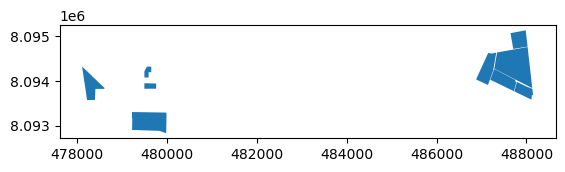

In [21]:
plan.plot()

In [22]:
plan['area'].sum()

153.36618588652172

In [23]:
#RECALCULAR EL AREA
plan['area'] = plan.geometry.area / 10000

In [24]:
plan['area'].sum()

153.3661858865217

In [25]:
# carga el shp de planificacion
gdf_plan = gpd.read_file(path_plan)

In [26]:
# determina el ultimo id
last_id = 0
if gdf_plan['id'].max() > 0:
    last_id = gdf_plan['id'].max()
else:
    last_id = 0

In [27]:
last_id

56

In [28]:
# Asignar valores incrementales a la columna 'id' empezando desde last_id + 1
plan['id'] = range(last_id + 1, last_id + 1 + len(plan))

In [29]:
plan

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,os,id
453,299.0,CITTCA,1530.0,C.I.T.T.C.A.,N25,3.127608,0.0,124,"POLYGON ((479500.907 8093827.318, 479495.821 8...",5,57
454,299.0,CITTCA,1530.0,C.I.T.T.C.A.,N23,2.707825,0.0,124,"POLYGON ((479496.561 8094203.672, 479503.064 8...",5,58
2138,299.0,CITTCA,1530.0,C.I.T.T.C.A.,N3,16.030289,0.0,124,"POLYGON ((478115.791 8094316.762, 478333.064 8...",5,59
2162,299.0,CITTCA,1530.0,C.I.T.T.C.A.,S3,31.245430,0.0,124,"POLYGON ((479981.054 8092840.174, 479980.204 8...",5,60
7557,577.0,SAN ANTONIO--IAG,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,L3,14.046489,0.0,50,"POLYGON ((487193.395 8094028.850, 487262.759 8...",5,61
7558,577.0,SAN ANTONIO--IAG,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,L4,16.907230,0.0,50,"POLYGON ((487326.883 8094631.099, 487256.226 8...",5,62
7560,577.0,SAN ANTONIO--IAG,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,L2,8.892186,0.0,50,"POLYGON ((487789.363 8093979.038, 487947.338 8...",5,63
7562,577.0,SAN ANTONIO--IAG,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,L1,48.404143,0.0,50,"POLYGON ((487345.806 8094635.527, 488024.724 8...",5,64
7564,577.0,SAN ANTONIO--IAG,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,L5,12.004987,0.0,50,"POLYGON ((488023.791 8094765.791, 487704.816 8...",5,65


In [30]:
len(plan)

9

In [31]:
# union de los dos gdf
gdf_pla_gral = pd.concat([gdf_plan, plan], ignore_index=True)

In [32]:
gdf_pla_gral['area'].sum()

867.7322704244875

In [33]:
gdf_pla_gral['unidad_01'] = gdf_pla_gral['unidad_01'].astype(int)
gdf_pla_gral['unidad_03'] = gdf_pla_gral['unidad_03'].astype(int)
gdf_pla_gral['os'] = gdf_pla_gral['os'].astype(int)
gdf_pla_gral['soca'] = gdf_pla_gral['soca'].astype(int)
gdf_pla_gral['id'] = gdf_pla_gral['id'].astype(int)
gdf_pla_gral['inst'] = gdf_pla_gral['inst'].astype(int)

In [34]:
gdf_pla_gral

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,os,soca,id,inst,idd,geometry
0,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L31,30.260942,1,2,1,50,1.0,"POLYGON ((504085.659 8094406.031, 503737.808 8..."
1,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L16,23.216246,1,4,2,50,1.0,"POLYGON ((504352.053 8094797.970, 504272.088 8..."
2,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L6,19.683505,1,5,3,50,1.0,"POLYGON ((503260.583 8094596.306, 503714.735 8..."
3,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L35,7.795719,1,4,4,50,1.0,"POLYGON ((504693.348 8094607.629, 504673.327 8..."
4,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L34,7.048921,1,5,5,50,1.0,"POLYGON ((504137.327 8094415.183, 504648.080 8..."
...,...,...,...,...,...,...,...,...,...,...,...,...
60,577,SAN ANTONIO--IAG,41594,AGROPECUARIA CAMPO DULCE S.R.L.,L3,14.046489,5,0,61,50,NaN,"POLYGON ((487193.395 8094028.850, 487262.759 8..."
61,577,SAN ANTONIO--IAG,41594,AGROPECUARIA CAMPO DULCE S.R.L.,L4,16.907230,5,0,62,50,NaN,"POLYGON ((487326.883 8094631.099, 487256.226 8..."
62,577,SAN ANTONIO--IAG,41594,AGROPECUARIA CAMPO DULCE S.R.L.,L2,8.892186,5,0,63,50,NaN,"POLYGON ((487789.363 8093979.038, 487947.338 8..."
63,577,SAN ANTONIO--IAG,41594,AGROPECUARIA CAMPO DULCE S.R.L.,L1,48.404143,5,0,64,50,NaN,"POLYGON ((487345.806 8094635.527, 488024.724 8..."


In [35]:
# exportar los datos en nuevo shp
gdf_pla_gral.to_file(path_plan)

# CARGAR PLANIFICACION A AMIGOCLOUD

In [36]:
def convertir_a_multipolygon(geometry):
    if isinstance(geometry, Polygon):
        return MultiPolygon([geometry])
    return geometry

def convertir_a_wkb(polygon):
    wkb_data = wkb.dumps(polygon, hex=True)
    return wkb_data

In [37]:
# repreyectar a WGS84
gdf_pla_gral = plan.to_crs(epsg=4326)
# convertir poligonos a multipoligonos
gdf_pla_gral['geometry'] = gdf_pla_gral['geometry'].apply(convertir_a_multipolygon)

In [38]:
gdf_pla_gral['unidad_01'] = gdf_pla_gral['unidad_01'].astype(int)
gdf_pla_gral['unidad_03'] = gdf_pla_gral['unidad_03'].astype(int)
gdf_pla_gral['os'] = gdf_pla_gral['os'].astype(int)
gdf_pla_gral['soca'] = gdf_pla_gral['soca'].astype(int)
gdf_pla_gral['id'] = gdf_pla_gral['id'].astype(int)
gdf_pla_gral['inst'] = gdf_pla_gral['inst'].astype(int)

In [39]:
len(gdf_pla_gral)

9

In [40]:
# recorrer el gdf de lotes y cargarlo a amigocloud
id_proyecto = f'https://app.amigocloud.com/api/v1/projects/35248/sql'
for index, row in gdf_pla_gral.iterrows():
    wkb_hex = convertir_a_wkb(row['geometry'])
    insert_sql = f"""
    INSERT INTO dataset_360912 (id, unidad_01, unidad_02, unidad_03, unidad_04, unidad_05, area, os, geometry)
    VALUES ({row['id']}, {row['unidad_01']}, '{row['unidad_02']}', {row['unidad_03']}, '{row['unidad_04']}', '{row['unidad_05']}', {row['area']}, '{row['os']}', ST_SetSRID(ST_GeomFromWKB('\\x{wkb_hex}'), 4326));
    """
    query_sql = {'query': insert_sql}
    resultado_post = amigocloud.post(id_proyecto, query_sql)

# CARGAR XLSX

In [41]:
from openpyxl import load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from datetime import datetime

In [42]:
# Cargar el archivo Excel
sheet_name = 'DATA'
table_name = 'tbl_data'

In [43]:
excel_data = pd.read_excel(path_xlsx_parte)

In [44]:
gdf_pla_gral

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,os,id
453,299,CITTCA,1530,C.I.T.T.C.A.,N25,3.127608,0,124,"MULTIPOLYGON (((-63.19283 -17.24052, -63.19288...",5,57
454,299,CITTCA,1530,C.I.T.T.C.A.,N23,2.707825,0,124,"MULTIPOLYGON (((-63.19287 -17.23711, -63.19281...",5,58
2138,299,CITTCA,1530,C.I.T.T.C.A.,N3,16.030289,0,124,"MULTIPOLYGON (((-63.20585 -17.23608, -63.20381...",5,59
2162,299,CITTCA,1530,C.I.T.T.C.A.,S3,31.245430,0,124,"MULTIPOLYGON (((-63.18832 -17.24944, -63.18833...",5,60
7557,577,SAN ANTONIO--IAG,41594,AGROPECUARIA CAMPO DULCE S.R.L.,L3,14.046489,0,50,"MULTIPOLYGON (((-63.12047 -17.23875, -63.11981...",5,61
7558,577,SAN ANTONIO--IAG,41594,AGROPECUARIA CAMPO DULCE S.R.L.,L4,16.907230,0,50,"MULTIPOLYGON (((-63.11921 -17.23331, -63.11988...",5,62
7560,577,SAN ANTONIO--IAG,41594,AGROPECUARIA CAMPO DULCE S.R.L.,L2,8.892186,0,50,"MULTIPOLYGON (((-63.11486 -17.23920, -63.11338...",5,63
7562,577,SAN ANTONIO--IAG,41594,AGROPECUARIA CAMPO DULCE S.R.L.,L1,48.404143,0,50,"MULTIPOLYGON (((-63.11903 -17.23327, -63.11264...",5,64
7564,577,SAN ANTONIO--IAG,41594,AGROPECUARIA CAMPO DULCE S.R.L.,L5,12.004987,0,50,"MULTIPOLYGON (((-63.11265 -17.23209, -63.11565...",5,65


In [45]:
new_data = {
    'INSTITUCION':list(gdf_pla_gral['inst']), 
    'COD CANERO': list(gdf_pla_gral['unidad_03']),
    'NOMBRE CANERO': list(gdf_pla_gral['unidad_04']),
    'COD PROPIEDAD': list(gdf_pla_gral['unidad_01']),
    'NOMBRE PROPIEDAD': list(gdf_pla_gral['unidad_02']),
    'LOTE': list(gdf_pla_gral['unidad_05']),
    'HECTAREA': list(gdf_pla_gral['area']),
    'CICLO': list(gdf_pla_gral['soca']),
    'ID': list(gdf_pla_gral['id']),
    'OS': list(gdf_pla_gral['os'])
}

new_df = pd.DataFrame(new_data)

In [46]:
new_df

,INSTITUCION,COD CANERO,NOMBRE CANERO,COD PROPIEDAD,NOMBRE PROPIEDAD,LOTE,HECTAREA,CICLO,ID,OS
0,124,1530,C.I.T.T.C.A.,299,CITTCA,N25,3.127608,0,57,5
1,124,1530,C.I.T.T.C.A.,299,CITTCA,N23,2.707825,0,58,5
2,124,1530,C.I.T.T.C.A.,299,CITTCA,N3,16.030289,0,59,5
3,124,1530,C.I.T.T.C.A.,299,CITTCA,S3,31.245430,0,60,5
4,50,41594,AGROPECUARIA CAMPO DULCE S.R.L.,577,SAN ANTONIO--IAG,L3,14.046489,0,61,5
5,50,41594,AGROPECUARIA CAMPO DULCE S.R.L.,577,SAN ANTONIO--IAG,L4,16.907230,0,62,5
6,50,41594,AGROPECUARIA CAMPO DULCE S.R.L.,577,SAN ANTONIO--IAG,L2,8.892186,0,63,5
7,50,41594,AGROPECUARIA CAMPO DULCE S.R.L.,577,SAN ANTONIO--IAG,L1,48.404143,0,64,5
8,50,41594,AGROPECUARIA CAMPO DULCE S.R.L.,577,SAN ANTONIO--IAG,L5,12.004987,0,65,5


In [47]:
new_df['MEZCLA'] = 0
new_df['LABOR_REALIZADA'] = 'PUL. CON DRONE'
new_df['Nº DE LABOR'] = 'PA-2025-1'

In [48]:
new_df

,INSTITUCION,COD CANERO,NOMBRE CANERO,COD PROPIEDAD,NOMBRE PROPIEDAD,LOTE,HECTAREA,CICLO,ID,OS,MEZCLA,LABOR_REALIZADA,Nº DE LABOR
0,124,1530,C.I.T.T.C.A.,299,CITTCA,N25,3.127608,0,57,5,0,PUL. CON DRONE,PA-2025-1
1,124,1530,C.I.T.T.C.A.,299,CITTCA,N23,2.707825,0,58,5,0,PUL. CON DRONE,PA-2025-1
2,124,1530,C.I.T.T.C.A.,299,CITTCA,N3,16.030289,0,59,5,0,PUL. CON DRONE,PA-2025-1
3,124,1530,C.I.T.T.C.A.,299,CITTCA,S3,31.245430,0,60,5,0,PUL. CON DRONE,PA-2025-1
4,50,41594,AGROPECUARIA CAMPO DULCE S.R.L.,577,SAN ANTONIO--IAG,L3,14.046489,0,61,5,0,PUL. CON DRONE,PA-2025-1
5,50,41594,AGROPECUARIA CAMPO DULCE S.R.L.,577,SAN ANTONIO--IAG,L4,16.907230,0,62,5,0,PUL. CON DRONE,PA-2025-1
6,50,41594,AGROPECUARIA CAMPO DULCE S.R.L.,577,SAN ANTONIO--IAG,L2,8.892186,0,63,5,0,PUL. CON DRONE,PA-2025-1
7,50,41594,AGROPECUARIA CAMPO DULCE S.R.L.,577,SAN ANTONIO--IAG,L1,48.404143,0,64,5,0,PUL. CON DRONE,PA-2025-1
8,50,41594,AGROPECUARIA CAMPO DULCE S.R.L.,577,SAN ANTONIO--IAG,L5,12.004987,0,65,5,0,PUL. CON DRONE,PA-2025-1


In [49]:
final_data = pd.concat([excel_data, new_df], ignore_index=True)

In [50]:
final_data.to_excel(path_xlsx_parte, index=False)